## import libraries

In [12]:
import os
import gc
import cv2
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision

import torchmetrics

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict, Counter

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold

# For Image Models
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

## training configuration

In [13]:
CONFIG = {
    "seed": 42,
    "epochs": 10,
    "img_size": 2048,
    "model_name": "tf_efficientnet_b0_ns",
    "pretrained" : "/kaggle/input/ubcfinetune-cnn-without-thumbnails/Recall0.9178_Acc0.9437_Loss0.1685_epoch9.bin",
    "label_pkl" : "/kaggle/input/ubcfinetune-cnn-without-thumbnails/label_encoder.pkl",
    "num_classes": 5,
    "train_batch_size":2,
    "valid_batch_size": 4,
    "learning_rate": 2e-5,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-6,
    "T_max": 500,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 10,
    "n_accumulate": 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

## set seed for reproducibility

In [14]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [15]:
ROOT_DIR = '/kaggle/input/ubc-crop-training-raw-images'
TEST_DIR = '/kaggle/input/UBC-OCEAN/test_images'


## read the data

In [16]:
df_ori = pd.read_csv("/kaggle/input/UBC-OCEAN/train.csv")
df_ori

,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False
2,91,HGSC,3388,3388,True
3,281,LGSC,42309,15545,False
4,286,EC,37204,30020,False
...,...,...,...,...,...
533,65022,LGSC,53355,46675,False
534,65094,MC,55042,45080,False
535,65300,HGSC,75860,27503,False
536,65371,HGSC,42551,41800,False


In [17]:
tma_list = list(df_ori[df_ori["is_tma"]==True]["image_id"].values)
bad_list = [281,3222, 5264, 9154, 12244, 26124, 31793, 32192, 33839, 41099,52308, 54506, 63836, 1289, 32035, 34822]
excluded_list = tma_list + bad_list


df = pd.read_csv(f"{ROOT_DIR}/train.csv")
df = df[~(df["image_id"].isin(excluded_list))].reset_index()
df["file_path"] = df["file_path"].apply(lambda x: f"{ROOT_DIR}/{x}" )

In [18]:
df.loc[df["image_id"]==15583, "label"] = "MC"

In [19]:
df["label"].unique()

array(['HGSC', 'LGSC', 'EC', 'CC', 'MC'], dtype=object)

In [20]:
encoder = joblib.load(CONFIG["label_pkl"]) 

In [21]:
df['label_str'] = df['label']
df_ori["label"] = encoder.fit_transform(df_ori['label'])
df['label'] = encoder.transform(df['label_str'])

with open("label_encoder.pkl", "wb") as fp:
    joblib.dump(encoder, fp)

In [22]:
df

,index,sx,ex,sy,ey,image_id,label,ori_width,ori_height,crop_id,file_path,weight,label_str
0,0,0,2433,0,2047,4,2,2434,2048,0,/kaggle/input/ubc-crop-training-raw-images/ima...,0.999101,HGSC
1,1,0,2075,0,2047,66,3,2076,2048,0,/kaggle/input/ubc-crop-training-raw-images/ima...,0.999030,LGSC
2,5,0,2537,0,2047,286,1,2538,2048,0,/kaggle/input/ubc-crop-training-raw-images/ima...,0.999118,EC
3,6,0,2047,0,2095,431,2,2048,2096,0,/kaggle/input/ubc-crop-training-raw-images/ima...,0.999035,HGSC
4,7,0,2046,0,2046,706,2,5963,2047,0,/kaggle/input/ubc-crop-training-raw-images/ima...,0.342948,HGSC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,793,0,2499,0,2047,65094,4,2500,2048,0,/kaggle/input/ubc-crop-training-raw-images/ima...,0.999112,MC
749,794,78,2125,0,2047,65300,2,5648,2048,0,/kaggle/input/ubc-crop-training-raw-images/ima...,0.362252,HGSC
750,795,3560,5607,0,2047,65300,2,5648,2048,1,/kaggle/input/ubc-crop-training-raw-images/ima...,0.362252,HGSC
751,796,0,2083,0,2047,65371,2,2084,2048,0,/kaggle/input/ubc-crop-training-raw-images/ima...,0.999032,HGSC


In [23]:
Counter(df["label"].values)

Counter({2: 325, 1: 160, 0: 152, 3: 62, 4: 54})

In [24]:
CLASS_WEIGHTS = Counter(df["label"].values)
CLASS_WEIGHTS = [ df.shape[0] / CLASS_WEIGHTS[i] for i in sorted(df["label"].unique()) ]
CLASS_WEIGHTS = [ val / sum(CLASS_WEIGHTS) for val in CLASS_WEIGHTS ]
CLASS_WEIGHTS


[0.13013851900427825,
 0.12363159305406435,
 0.060864784272770145,
 0.3190492723975854,
 0.3663158312713018]

## create folds

In [25]:
skf = StratifiedGroupKFold(n_splits=CONFIG['n_fold'], shuffle=True, random_state=CONFIG["seed"])

for fold, ( _, val_) in enumerate(skf.split(X=df, y=df.label, groups=df.image_id)):
      df.loc[val_ , "kfold"] = int(fold)


In [26]:
CONFIG['T_max'] = df[df["kfold"]!=CONFIG["fold"]].shape[0] * CONFIG['epochs'] // CONFIG['train_batch_size']
CONFIG['T_max']

3345

## dataset class

In [27]:
class UBCDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.labels = df['label'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.labels[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'label': torch.tensor(label, dtype=torch.long)
        }

## augmentations

In [28]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Flip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=1.0),
        A.ShiftScaleRotate(shift_limit=0.1, 
                           scale_limit=0.15, 
                           rotate_limit=60, 
                           p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.),
    
    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

In [29]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'


## create model

In [30]:
class UBCModel(nn.Module):
    def __init__(self, model_name, num_classes, pretrained=None):
        super(UBCModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)

        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        self.pooling = GeM()
        self.linear = nn.Linear(in_features, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, images):
        features = self.model(images)
        pooled_features = self.pooling(features).flatten(1)
        output = self.linear(pooled_features)
        return output

    
model = UBCModel(CONFIG['model_name'], CONFIG['num_classes'])
model.to(CONFIG['device']);

In [31]:
if "pretrained" in CONFIG:
    model.load_state_dict( torch.load(CONFIG["pretrained"]))

## loss function

In [32]:
def criterion(outputs, labels):
    return nn.CrossEntropyLoss( weight = torch.tensor(CLASS_WEIGHTS).cuda() )(outputs, labels)

## training function

In [33]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    running_acc  = 0.0
    running_recall = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        labels = data['label'].to(device, dtype=torch.long)
        
        batch_size = images.size(0)
        
        outputs = model(images)
        loss = criterion(outputs, labels)        
        loss = loss / CONFIG['n_accumulate']
            
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        _, predicted = torch.max(model.softmax(outputs), 1)
        acc = torch.sum( predicted == labels )
        recall_nn = torchmetrics.Recall(task="multiclass", average='macro', num_classes=CONFIG["num_classes"]).cuda()
        recall = recall_nn(predicted, labels)
        
        running_loss += (loss.item() * batch_size)
        running_acc  += acc.item()
        running_recall += (recall.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_acc = running_acc / dataset_size
        epoch_recall = running_recall / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, Train_Acc=epoch_acc, Train_Recall=epoch_recall,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss, epoch_acc, epoch_recall

## validation function

In [34]:
@torch.inference_mode()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    running_acc = 0.0
    running_recall = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        images = data['image'].to(device, dtype=torch.float)
        labels = data['label'].to(device, dtype=torch.long)
        
        batch_size = images.size(0)

        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(model.softmax(outputs), 1)
        acc = torch.sum( predicted == labels )
        
        recall_nn = torchmetrics.Recall(task="multiclass", average='macro', num_classes=CONFIG["num_classes"]).cuda()
        recall = recall_nn(predicted, labels)

        running_loss += (loss.item() * batch_size)
        running_acc  += acc.item()
        running_recall += (recall.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_acc = running_acc / dataset_size
        epoch_recall = running_recall / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, Valid_Acc=epoch_acc, Valid_Recall=epoch_recall,
                        LR=optimizer.param_groups[0]['lr'])   
    
    gc.collect()
    
    return epoch_loss, epoch_acc, epoch_recall


## run training

In [35]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_recall = -np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss, train_epoch_acc, train_epoch_recall = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, val_epoch_acc, val_epoch_recall = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Train Accuracy'].append(train_epoch_acc)
        history['Valid Accuracy'].append(val_epoch_acc)
        history['Train Recall'].append(train_epoch_recall)
        history['Valid Recall'].append(val_epoch_recall)
        history['lr'].append( scheduler.get_lr()[0] )
        
        # deep copy the model
        if best_epoch_recall <= val_epoch_recall:
            print(f"{b_}Validation Recall Improved ({best_epoch_recall} ---> {val_epoch_recall})")
            best_epoch_recall = val_epoch_recall
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "Recall{:.4f}_Acc{:.4f}_Loss{:.4f}_epoch{:.0f}.bin".format(val_epoch_recall, val_epoch_acc, val_epoch_loss, epoch)
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Recall: {:.4f}".format(best_epoch_recall))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [36]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler


In [37]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = UBCDataset(df_train, transforms=data_transforms["train"])
    valid_dataset = UBCDataset(df_valid, transforms=data_transforms["valid"])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader


## preprare dataset loaders

In [38]:
train_loader, valid_loader = prepare_loaders(df, fold=CONFIG["fold"])


## define optimizer and scheduler

In [39]:
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], 
                       weight_decay=CONFIG['weight_decay'])
scheduler = fetch_scheduler(optimizer)


## start training

In [40]:
model, history = run_training(model, optimizer, scheduler,
                              device=CONFIG['device'],
                              num_epochs=CONFIG['epochs'])


[INFO] Using GPU: Tesla P100-PCIE-16GB



100%|██████████| 21/21 [00:12<00:00,  1.66it/s, Epoch=1, LR=1.95e-5, Valid_Acc=0.94, Valid_Loss=0.151, Valid_Recall=0.937] 


Validation Recall Improved (-inf ---> 0.9365079388732002)
Model Saved



100%|██████████| 21/21 [00:10<00:00,  1.92it/s, Epoch=2, LR=1.82e-5, Valid_Acc=0.893, Valid_Loss=0.212, Valid_Recall=0.881]


100%|██████████| 21/21 [00:11<00:00,  1.80it/s, Epoch=3, LR=1.61e-5, Valid_Acc=0.94, Valid_Loss=0.196, Valid_Recall=0.939] 


Validation Recall Improved (0.9365079388732002 ---> 0.9391534427801768)
Model Saved



100%|██████████| 21/21 [00:11<00:00,  1.84it/s, Epoch=4, LR=1.35e-5, Valid_Acc=0.929, Valid_Loss=0.201, Valid_Recall=0.931]


100%|██████████| 21/21 [00:11<00:00,  1.85it/s, Epoch=5, LR=1.05e-5, Valid_Acc=0.94, Valid_Loss=0.17, Valid_Recall=0.939]  


Validation Recall Improved (0.9391534427801768 ---> 0.9391534427801768)
Model Saved



100%|██████████| 21/21 [00:11<00:00,  1.86it/s, Epoch=6, LR=7.59e-6, Valid_Acc=0.952, Valid_Loss=0.147, Valid_Recall=0.96] 


Validation Recall Improved (0.9391534427801768 ---> 0.960317462682724)
Model Saved



100%|██████████| 21/21 [00:11<00:00,  1.87it/s, Epoch=7, LR=4.94e-6, Valid_Acc=0.94, Valid_Loss=0.182, Valid_Recall=0.952] 


100%|██████████| 21/21 [00:11<00:00,  1.81it/s, Epoch=8, LR=2.84e-6, Valid_Acc=0.94, Valid_Loss=0.237, Valid_Recall=0.939] 


100%|██████████| 21/21 [00:11<00:00,  1.81it/s, Epoch=9, LR=1.48e-6, Valid_Acc=0.964, Valid_Loss=0.127, Valid_Recall=0.966]


Validation Recall Improved (0.960317462682724 ---> 0.9656084676583608)
Model Saved



100%|██████████| 21/21 [00:11<00:00,  1.86it/s, Epoch=10, LR=1e-6, Valid_Acc=0.917, Valid_Loss=0.203, Valid_Recall=0.923]



Training complete in 0h 35m 58s
Best Recall: 0.9656


In [41]:
history = pd.DataFrame.from_dict(history)
history.to_csv("history.csv", index=False)

## logs

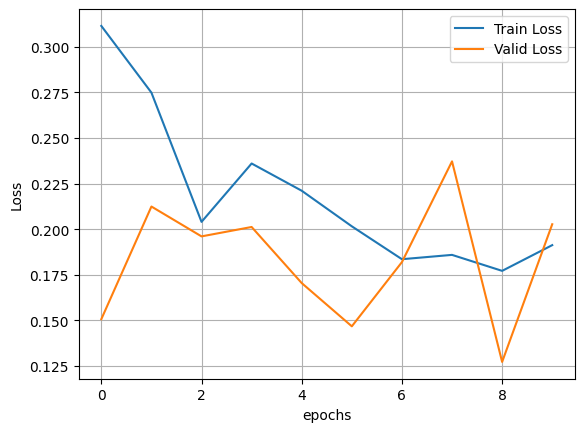

In [42]:
plt.plot( range(history.shape[0]), history["Train Loss"].values, label="Train Loss")
plt.plot( range(history.shape[0]), history["Valid Loss"].values, label="Valid Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()


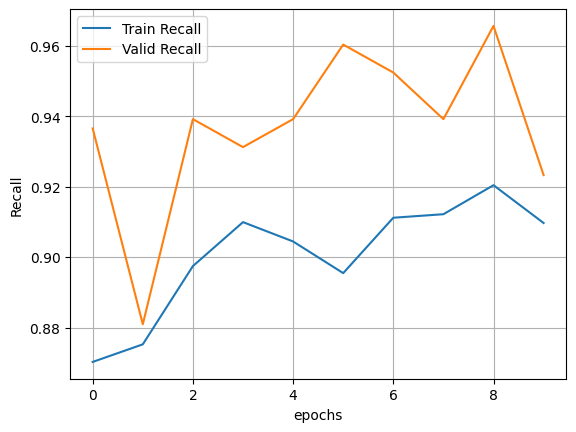

In [43]:
plt.plot( range(history.shape[0]), history["Train Recall"].values, label="Train Recall")
plt.plot( range(history.shape[0]), history["Valid Recall"].values, label="Valid Recall")
plt.xlabel("epochs")
plt.ylabel("Recall")
plt.grid()
plt.legend()
plt.show()


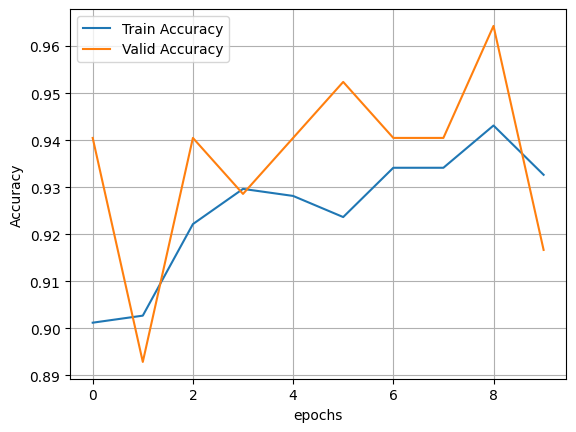

In [44]:
plt.plot( range(history.shape[0]), history["Train Accuracy"].values, label="Train Accuracy")
plt.plot( range(history.shape[0]), history["Valid Accuracy"].values, label="Valid Accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()


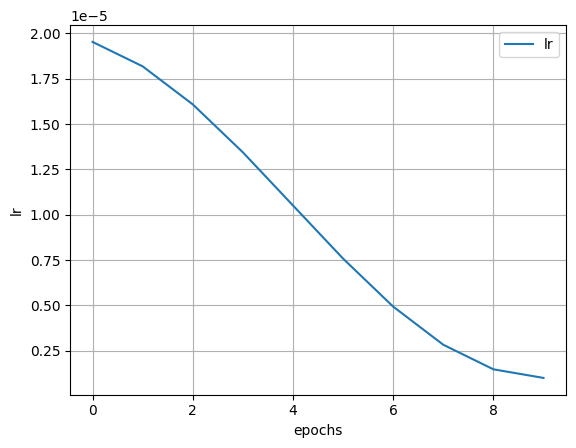

In [45]:
plt.plot( range(history.shape[0]), history["lr"].values, label="lr")
plt.xlabel("epochs")
plt.ylabel("lr")
plt.grid()
plt.legend()
plt.show()

## oof

In [46]:
oof_dataset = UBCDataset(df, transforms=data_transforms["valid"])
oof_loader = DataLoader(oof_dataset, batch_size=CONFIG['valid_batch_size'], num_workers=2, shuffle=False, pin_memory=True)

In [47]:
total_preds_conf = []
total_preds_label = []
with torch.no_grad():
    bar = tqdm(enumerate(oof_loader), total=len(oof_loader))
    for step, data in bar:        
        images = data['image'].to(CONFIG["device"], dtype=torch.float)        
        batch_size = images.size(0)
        outputs = model(images)
        preds_conf = model.softmax(outputs)
        _, preds_label = torch.max(preds_conf, 1)
        total_preds_conf.append( preds_conf.detach().cpu().numpy() )
        total_preds_label.append( preds_label.detach().cpu().numpy() )
total_preds_conf = np.concatenate(total_preds_conf, axis=0)
total_preds_label = np.concatenate(total_preds_label).flatten()
total_preds_label2 = encoder.inverse_transform( total_preds_label )


100%|██████████| 189/189 [01:34<00:00,  1.99it/s]


In [48]:
for i in range(total_preds_conf.shape[-1]):
    df[f"pred_conf_{i}"] = total_preds_conf[:, i]
df["pred_label"] = total_preds_label
df["pred_label_str"] = total_preds_label2
df.to_csv("oof.csv", index=False)

In [49]:
df

,index,sx,ex,sy,ey,image_id,label,ori_width,ori_height,crop_id,...,weight,label_str,kfold,pred_conf_0,pred_conf_1,pred_conf_2,pred_conf_3,pred_conf_4,pred_label,pred_label_str
0,0,0,2433,0,2047,4,2,2434,2048,0,...,0.999101,HGSC,4.0,1.764562e-04,0.017149,0.982054,6.099133e-04,1.146489e-05,2,HGSC
1,1,0,2075,0,2047,66,3,2076,2048,0,...,0.999030,LGSC,0.0,1.210116e-05,0.000041,0.011778,9.881691e-01,1.302192e-07,3,LGSC
2,5,0,2537,0,2047,286,1,2538,2048,0,...,0.999118,EC,1.0,1.174561e-05,0.992962,0.002796,4.012601e-03,2.182193e-04,1,EC
3,6,0,2047,0,2095,431,2,2048,2096,0,...,0.999035,HGSC,6.0,6.479897e-02,0.000140,0.863886,5.607464e-02,1.510046e-02,2,HGSC
4,7,0,2046,0,2046,706,2,5963,2047,0,...,0.342948,HGSC,0.0,8.937628e-07,0.000204,0.999674,1.143908e-04,6.380692e-06,2,HGSC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,793,0,2499,0,2047,65094,4,2500,2048,0,...,0.999112,MC,5.0,1.244459e-06,0.000233,0.000002,3.191248e-07,9.997633e-01,4,MC
749,794,78,2125,0,2047,65300,2,5648,2048,0,...,0.362252,HGSC,5.0,4.113938e-01,0.116485,0.405042,4.749504e-04,6.660465e-02,0,CC
750,795,3560,5607,0,2047,65300,2,5648,2048,1,...,0.362252,HGSC,5.0,7.663652e-04,0.002480,0.995570,7.056105e-05,1.113524e-03,2,HGSC
751,796,0,2083,0,2047,65371,2,2084,2048,0,...,0.999032,HGSC,1.0,1.739051e-02,0.079566,0.859540,4.281557e-02,6.882057e-04,2,HGSC


In [50]:
torch.save(model.state_dict(),"efficienetnetb0_s_wsi.bin")